# Superparamagnetic Network - Control of magnetization through anistropy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

## The Stoner-Wolfarth model

The goal is to influence $m_{eq}$ by applying a strain on the magnet, which will change the anisotropy of the system. If the strain induces an anistropy $K_\sigma$ forming an angle $\phi$ with the easy axis, the energy will read:

$$E(\theta) = KV\sin^2{\theta} + K_\sigma V\sin^2{(\theta-\phi)} - \mu_0M_SVH\cos{(\theta-\theta_H)}$$

Which can be wrote:

$$E(\theta) = \tilde{K}V\sin^2{(\theta-\psi)} - \mu_0M_SVH\cos{(\theta-\theta_H)}$$

where

$$\tilde{K} = \sqrt{\left(K+K_\sigma\cos{(2\phi)}\right)^2 +\left(K_\sigma\sin{(2\phi)}\right)^2}$$

$$\psi = \frac{1}{2}\arctan{\left(\frac{K_\sigma\sin{(2\phi)}}{K+K_\sigma\cos{(2\phi)}}\right)}$$

The control paramter is  $K_\sigma$, which influences the angle $\psi$ and $\tilde{K}$.

## Arrhenius equation

We are facing a two-states system with two barriers ($E^-_{b}$ and $E^+_{b}$) of energy. For the moment, we will write de transition rate like this:

$$\omega = \frac{1}{\tau} = f^-_{0}\exp{\left(\frac{-E^-_{b}}{K_BT}\right)}+f^+_{0}\exp{\left(\frac{-E^+_{b}}{K_BT}\right)}$$

We will fix $f_{0,-}=f_{0,+}=1$. We will call $T_{max}$ the temperature verifying $KV/(k_BT) = 3$. Above $T_{max}$, the Arrhenius law cannot be used anymore and our simulation is incorrect.

## Dimensionless equations

Let $e = \frac{E}{KV}$, $H_K = \frac{2K}{\mu_0M_S}$, $h=\frac{H}{H_K}$, $k_\sigma=\frac{K_\sigma}{K}$, $\omega'=\frac{\omega}{f_0}$ and $\beta'=\frac{KV}{k_BT}$. The energy of the system now reads:

$$e(\theta) = \tilde{k}\sin^2{(\theta-\psi)} - 2h\cos{(\theta-\theta_H)}$$

where

$$\tilde{k} = \sqrt{\left(1+k_\sigma\cos{(2\phi)}\right)^2 +\left(k_\sigma\sin{(2\phi)}\right)^2}$$

$$\psi = \frac{1}{2}\arctan{\left(\frac{k_\sigma\sin{(2\phi)}}{1+k_\sigma\cos{(2\phi)}}\right)}$$

The Arrhenius law becomes:

$$\omega' = \exp{\left(-e^-_{b}\beta'\right)}+\exp{\left(-e^+_{b}\beta'\right)}$$

The condition to use this law is to have $e_{b,min}\beta'\geq3$. If this condition is not observed, we **will simply not plot the function**.

## Superparamagnetic network class

In [95]:
#Dimensionless equations
def k_tilde(spn):
    return(np.sqrt((1+spn.k_s*np.cos(2*spn.phi*np.pi/180))**2+(spn.k_s*np.sin(2*spn.phi*np.pi/180))**2))

def psi(spn):
    return(180*np.arctan2(spn.k_s*np.sin(2*spn.phi*np.pi/180),(1+spn.k_s*np.cos(2*spn.phi*np.pi/180)))/2/np.pi)
        
def energy(spn,theta):
    return(k_tilde(spn)*np.sin((theta-psi(spn))*np.pi/180)**2-2*spn.h*np.cos((theta-spn.theta_H)*np.pi/180))

#Computation of energy barriers
def calculate_energy_barriers(spn):
    theta = np.linspace(-180,180,1000)
    E = energy(spn,theta)
    
    #Localization of extrema
    id_max = argrelextrema(E, np.greater)[0]
    id_min = argrelextrema(E, np.less)[0]
    ind1 = 0
    ind2 = 1
    
    #Two-states case
    if(len(id_max)==2 and len(id_min)==2):
        if (theta[id_min[0]]<(-90)):
            ind1 = 1
            ind2 = 0
        theta_1 = theta[id_min[ind1]]
        theta_2 = theta[id_min[ind2]]
        e_12_big = max((E[id_max[0]]-E[id_min[ind1]]),(E[id_max[1]]-E[id_min[ind1]]))
        e_21_big = max((E[id_max[0]]-E[id_min[ind2]]),(E[id_max[1]]-E[id_min[ind2]]))
        e_12_small = min((E[id_max[0]]-E[id_min[ind1]]),(E[id_max[1]]-E[id_min[ind1]]))
        e_21_small = min((E[id_max[0]]-E[id_min[ind2]]),(E[id_max[1]]-E[id_min[ind2]]))
    
    #One minimum in 180°
    elif(len(id_min)==1 and len(id_max)==2):
        theta_1 = theta[id_min[0]]
        theta_2 = 180
        e_12_big = max((E[id_max[0]]-E[id_min[0]]),(E[id_max[1]]-E[id_min[0]]))
        e_21_big = max((E[id_max[0]]-energy(spn,180)),(E[id_max[1]]-energy(spn,180)))
        e_12_small = min((E[id_max[0]]-E[id_min[0]]),(E[id_max[1]]-E[id_min[0]]))
        e_21_small = min((E[id_max[0]]-energy(spn,180)),(E[id_max[1]]-energy(spn,180)))
        
    #One maximum in 180°
    elif(len(id_min)==2 and len(id_max)==1):
        if (theta[id_min[0]]<(-90)):
            ind1 = 1
            ind2 = 0
        theta_1 = theta[id_min[ind1]]
        theta_2 = theta[id_min[ind2]]
        e_12_big = max((E[id_max[0]]-E[id_min[ind1]]),(energy(spn,180)-E[id_min[ind1]]))
        e_21_big = max((E[id_max[0]]-E[id_min[ind2]]),(energy(spn,180)-E[id_min[ind2]]))
        e_12_small = min((E[id_max[0]]-E[id_min[ind1]]),(energy(spn,180)-E[id_min[ind1]]))
        e_21_small = min((E[id_max[0]]-E[id_min[ind2]]),(energy(spn,180)-E[id_min[ind2]]))
    
    #There might be only one minimum. In this case put nans for all parameters
    else:
        (theta_1,theta_2,e_12_big,e_21_big,e_12_small,e_21_small) = (np.nan,np.nan,np.nan,np.nan,np.nan,np.nan)
    
    #Check the condition e_b_min*beta_prime>=3
    e_b_min = min(e_12_small,e_21_small)
    if(e_b_min*spn.beta_prime<=3):
        (theta_1,theta_2,e_12_big,e_21_big,e_12_small,e_21_small) = (np.nan,np.nan,np.nan,np.nan,np.nan,np.nan)
    
    spn.theta_1 = theta_1
    spn.theta_2 = theta_2
    spn.e_12_small = e_12_small
    spn.e_21_small = e_21_small
    spn.e_12_big = e_12_big
    spn.e_21_big = e_21_big
    
    return()

In [5]:
#We define a superparamagnetic network as a class
class SP_Network:
    def __init__(self,h,theta_H,k_s,phi,beta_prime):
        self.h = h
        self.theta_H = theta_H
        self.k_s = k_s
        self.phi = phi
        self.beta_prime = beta_prime
        self.e_12_small = np.nan
        self.e_21_small = np.nan
        self.e_12_big = np.nan
        self.e_21_big = np.nan
        self.theta_1 = np.nan
        self.theta_2 = np.nan
    
    def get_energy_barriers(self):
        calculate_energy_barriers(self)
        return(self.theta_1,self.theta_2,self.e_12_small,self.e_21_small,self.e_12_big,self.e_21_big)
    
    def get_e_b_min(self):
        return(min(self.e_12_small,self.e_21_small))
    
    def get_omega_prime_12(self):
        return(np.exp(-self.e_12_small*self.beta_prime)+np.exp(-self.e_12_big*self.beta_prime))
    
    def get_omega_prime_21(self):
        return(np.exp(-self.e_21_small*self.beta_prime)+np.exp(-self.e_21_big*self.beta_prime))
    
    def get_omega_prime(self):
        return(self.get_omega_prime_12()+self.get_omega_prime_21())
    
    def get_theta_1(self):
        return(self.theta_1)
    
    def get_theta_2(self):
        return(self.theta_2)

In [100]:
#Computation
k_s_lim = 5
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,100)
Theta_1 = []
Theta_2 = []
E_12_small = []
E_21_small = []
E_12_big = []
E_21_big = []
E_b_min = []
for k_s in k_s_list:
    spn.k_s = k_s
    (theta_1,theta_2,e_12_small,e_21_small,e_12_big,e_21_big) = spn.get_energy_barriers()
    e_b_min = spn.get_e_b_min()
    Theta_1.append(theta_1)
    Theta_2.append(theta_2)
    E_12_small.append(e_12_small)
    E_21_small.append(e_21_small)
    E_12_big.append(e_12_big)
    E_21_big.append(e_21_big)
    E_b_min.append(e_b_min)

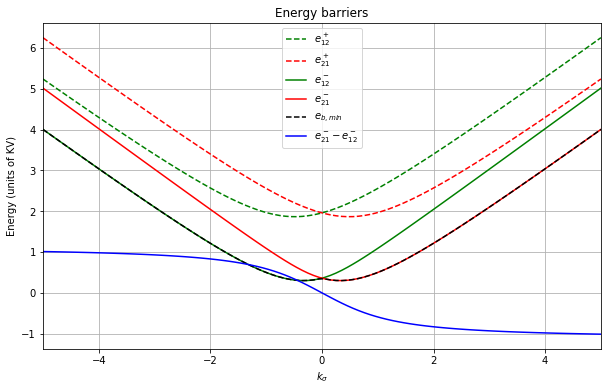

In [101]:
plt.figure(figsize = (10,6))
plt.plot(k_s_list,E_12_big,'g--',label=r'$e^+_{12}$')
plt.plot(k_s_list,E_21_big,'r--',label=r'$e^+_{21}$')
plt.plot(k_s_list,E_12_small,'g-',label=r'$e^-_{12}$')
plt.plot(k_s_list,E_21_small,'r-',label=r'$e^-_{21}$')
plt.plot(k_s_list,E_b_min,'k--',label=r'$e_{b,min}$')
plt.plot(k_s_list,np.array(E_21_small)-np.array(E_12_small),'b-',label=r'$e^-_{21}-e^-_{12}$')
plt.legend(loc = "best")
plt.xlim(-k_s_lim,k_s_lim)
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'Energy (units of KV)')
plt.title("Energy barriers")
plt.show()

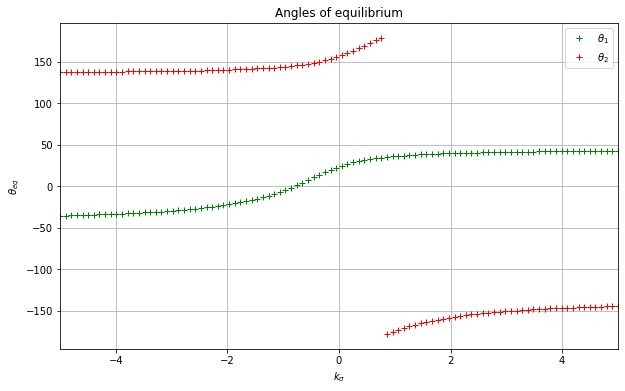

In [101]:
plt.figure(figsize = (10,6))
plt.plot(k_s_list,Theta_1,'g+',label=r'$\theta_1$')
plt.plot(k_s_list,Theta_2,'r+',label=r'$\theta_2$')
plt.legend(loc = "best")
plt.xlim(-k_s_lim,k_s_lim)
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$\theta_{eq}$')
plt.title("Angles of equilibrium")
plt.show()

## Behaviour of $\omega'$

$$\omega' = \omega'_{12} + \omega'_{21}$$

### 1. Influence of $\beta'$

In [134]:
#Computation
k_s_lim = 1
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
beta_prime_list = [1,2,5,10,50]
omega_vs_beta = []
for beta_prime in beta_prime_list:
    spn.beta_prime = beta_prime
    Omega_prime = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        Omega_prime.append(spn.get_omega_prime())
    omega_vs_beta.append(Omega_prime)

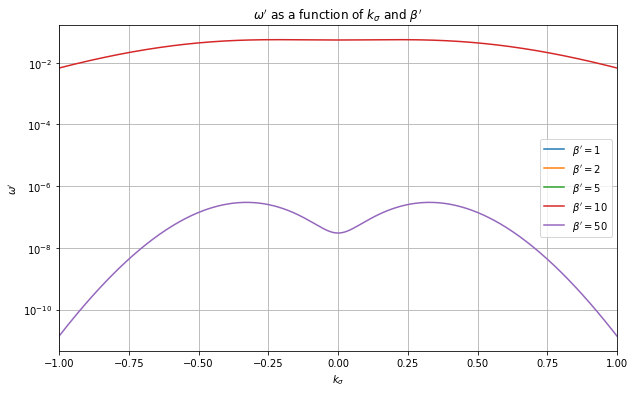

In [135]:
plt.figure(figsize=(10,6))
for i in range(len(beta_prime_list)):
    beta_prime = beta_prime_list[i]
    plt.plot(k_s_list,omega_vs_beta[i],label = r'$\beta^\prime = $'+str(beta_prime))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$\omega^\prime$')
plt.xlim(-k_s_lim,k_s_lim)
plt.yscale("log")
plt.title(r'$\omega^\prime$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\beta^\prime$')
plt.show()

### 2. Influence of $h$

In [114]:
#Computation
k_s_lim = 1
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
h_list = np.logspace(-3,0,5)
omega_vs_h = []
for h in h_list:
    spn.h = h
    Omega_prime = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        Omega_prime.append(spn.get_omega_prime())
    omega_vs_h.append(Omega_prime)

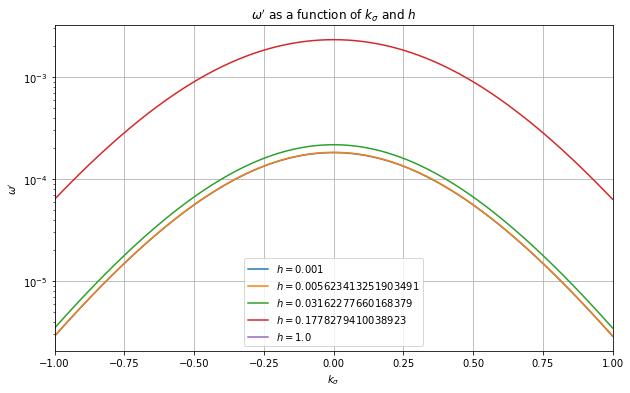

In [115]:
plt.figure(figsize=(10,6))
for i in range(len(h_list)):
    h = h_list[i]
    plt.plot(k_s_list,omega_vs_h[i],label = r'$h = $'+str(h))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$\omega^\prime$')
plt.xlim(-k_s_lim,k_s_lim)
plt.yscale("log")
plt.title(r'$\omega^\prime$' + " as a function of " + r'$k_\sigma$' + " and " + r'$h$')
plt.show()

### 3. influence of $\theta_H$

In [29]:
#Computation
k_s_lim = 5
spn = SP_Network(0.1,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
theta_H_list = np.linspace(90,0,5)
omega_vs_theta_H = []
for theta_H in theta_H_list:
    spn.theta_H = theta_H
    Omega_prime = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        Omega_prime.append(spn.get_omega_prime())
    omega_vs_theta_H.append(Omega_prime)

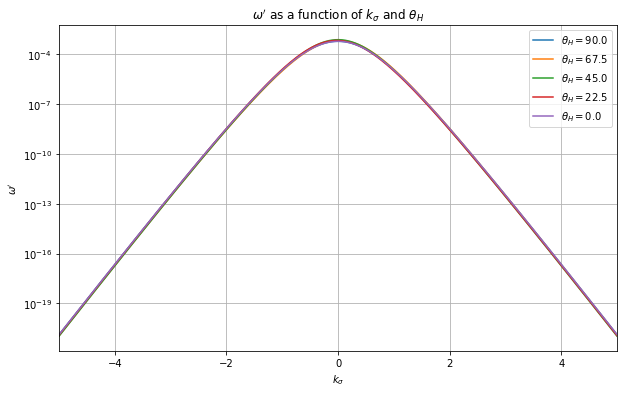

In [30]:
plt.figure(figsize=(10,6))
for i in range(len(theta_H_list)):
    theta_H = theta_H_list[i]
    plt.plot(k_s_list,omega_vs_theta_H[i],label = r'$\theta_H = $'+str(theta_H))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$\omega^\prime$')
plt.xlim(-k_s_lim,k_s_lim)
plt.yscale("log")
plt.title(r'$\omega^\prime$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\theta_H$')
plt.show()

### 4. Influence of $\phi$

In [31]:
#Computation
k_s_lim = 5
spn = SP_Network(0.1,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
phi_list = np.linspace(45,0,5)
omega_vs_phi = []
for phi in phi_list:
    spn.phi = phi
    Omega_prime = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        Omega_prime.append(spn.get_omega_prime())
    omega_vs_phi.append(Omega_prime)

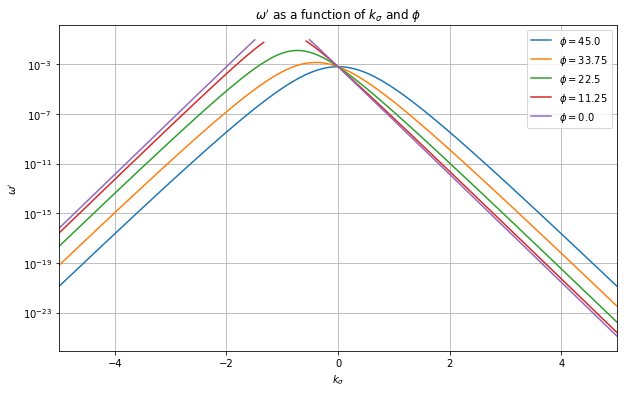

In [32]:
plt.figure(figsize=(10,6))
for i in range(len(phi_list)):
    phi = phi_list[i]
    plt.plot(k_s_list,omega_vs_phi[i],label = r'$\phi = $'+str(phi))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$\omega^\prime$')
plt.xlim(-k_s_lim,k_s_lim)
plt.yscale("log")
plt.title(r'$\omega^\prime$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\phi$')
plt.show()

## Behaviour of $p_{1,eq}$ and $p_{2,eq}$

$$p_{1,eq} = \frac{\omega_{21}}{\omega}$$

$$p_{2,eq} = \frac{\omega_{12}}{\omega}$$

### 1. Influence of $\beta'$

In [124]:
#Computation
k_s_lim = 1
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
beta_prime_list = [1,2,5,10,50]
p1_vs_bp = []
p2_vs_bp = []
for bp in beta_prime_list:
    spn.beta_prime = bp
    p1 = []
    p2 = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        p1.append(spn.get_omega_prime_21()/spn.get_omega_prime())
        p2.append(spn.get_omega_prime_12()/spn.get_omega_prime())
    p1_vs_bp.append(p1)
    p2_vs_bp.append(p2)

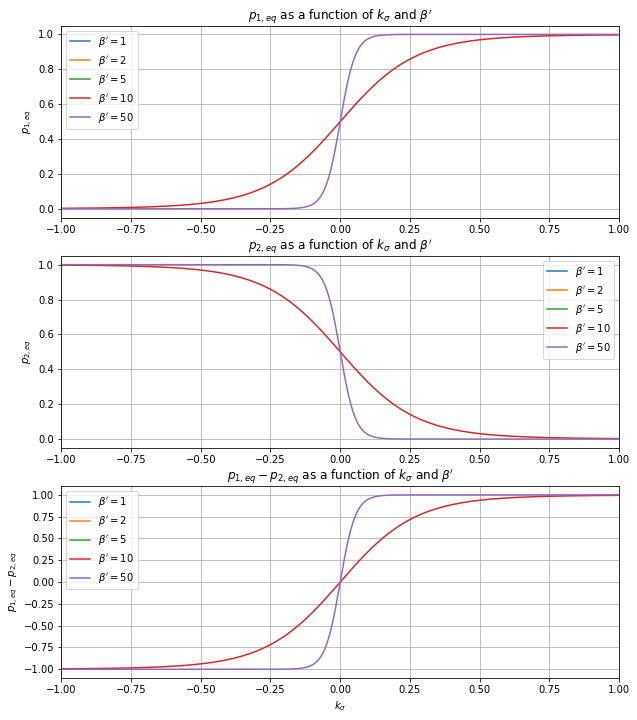

In [125]:
plt.figure(figsize=(10,12))

plt.subplot(311)
for i in range(len(beta_prime_list)):
    bp = beta_prime_list[i]
    plt.plot(k_s_list,p1_vs_bp[i],label = r'$\beta^\prime = $'+str(bp))
plt.legend(loc="best")
plt.grid(True)
#plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{1,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{1,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\beta^\prime$')

plt.subplot(312)
for i in range(len(beta_prime_list)):
    bp = beta_prime_list[i]
    plt.plot(k_s_list,p2_vs_bp[i],label = r'$\beta^\prime = $'+str(bp))
plt.legend(loc="best")
plt.grid(True)
#plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{2,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{2,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\beta^\prime$')

plt.subplot(313)
for i in range(len(beta_prime_list)):
    bp = beta_prime_list[i]
    plt.plot(k_s_list,np.array(p1_vs_bp[i])-np.array(p2_vs_bp[i]),label = r'$\beta^\prime = $'+str(bp))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{1,eq}-p_{2,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{1,eq}-p_{2,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\beta^\prime$')

plt.show()

### 2. Influence of $h$

In [35]:
#Computation
k_s_lim = 5
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
h_list = np.logspace(-2,0,5)
p1_vs_h = []
p2_vs_h = []
for h in h_list:
    spn.h = h
    p1 = []
    p2 = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        p1.append(spn.get_omega_prime_21()/spn.get_omega_prime())
        p2.append(spn.get_omega_prime_12()/spn.get_omega_prime())
    p1_vs_h.append(p1)
    p2_vs_h.append(p2)

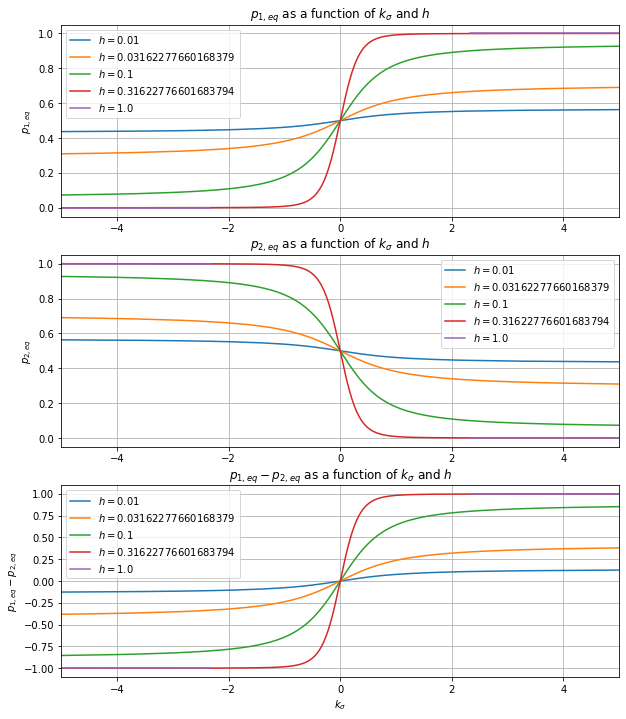

In [36]:
plt.figure(figsize=(10,12))

plt.subplot(311)
for i in range(len(h_list)):
    h = h_list[i]
    plt.plot(k_s_list,p1_vs_h[i],label = r'$h = $'+str(h))
plt.legend(loc="best")
plt.grid(True)
#plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{1,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{1,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$h$')

plt.subplot(312)
for i in range(len(h_list)):
    h = h_list[i]
    plt.plot(k_s_list,p2_vs_h[i],label = r'$h = $'+str(h))
plt.legend(loc="best")
plt.grid(True)
#plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{2,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{2,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$h$')

plt.subplot(313)
for i in range(len(h_list)):
    h = h_list[i]
    plt.plot(k_s_list,np.array(p1_vs_h[i])-np.array(p2_vs_h[i]),label = r'$h = $'+str(h))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{1,eq}-p_{2,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{1,eq}-p_{2,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$h$')

plt.show()

### 3. Influence of $\theta_H$

In [37]:
#Computation
k_s_lim = 5
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
theta_H_list = np.linspace(90,0,5)
p1_vs_th = []
p2_vs_th = []
for theta_H in theta_H_list:
    spn.theta_H = theta_H
    p1 = []
    p2 = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        p1.append(spn.get_omega_prime_21()/spn.get_omega_prime())
        p2.append(spn.get_omega_prime_12()/spn.get_omega_prime())
    p1_vs_th.append(p1)
    p2_vs_th.append(p2)

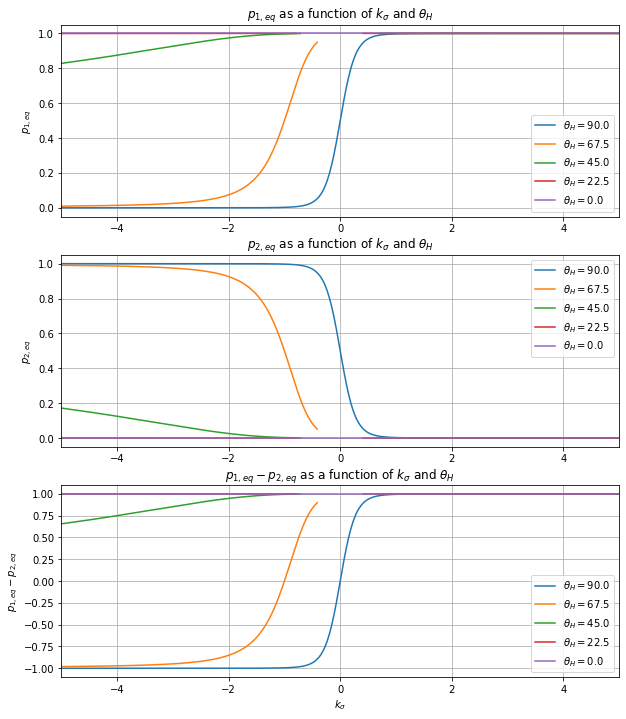

In [38]:
plt.figure(figsize=(10,12))

plt.subplot(311)
for i in range(len(theta_H_list)):
    theta_H = theta_H_list[i]
    plt.plot(k_s_list,p1_vs_th[i],label = r'$\theta_H = $'+str(theta_H))
plt.legend(loc="best")
plt.grid(True)
#plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{1,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{1,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\theta_H$')

plt.subplot(312)
for i in range(len(theta_H_list)):
    theta_H = theta_H_list[i]
    plt.plot(k_s_list,p2_vs_th[i],label = r'$\theta_H = $'+str(theta_H))
plt.legend(loc="best")
plt.grid(True)
#plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{2,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{2,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\theta_H$')

plt.subplot(313)
for i in range(len(theta_H_list)):
    theta_H = theta_H_list[i]
    plt.plot(k_s_list,np.array(p1_vs_th[i])-np.array(p2_vs_th[i]),label = r'$\theta_H = $'+str(theta_H))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{1,eq}-p_{2,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{1,eq}-p_{2,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\theta_H$')

plt.show()

### 4. Influence of $\phi$

In [39]:
#Computation
k_s_lim = 5
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
phi_list = np.linspace(45,0,5)
p1_vs_phi = []
p2_vs_phi = []
for phi in phi_list:
    spn.phi = phi
    p1 = []
    p2 = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        p1.append(spn.get_omega_prime_21()/spn.get_omega_prime())
        p2.append(spn.get_omega_prime_12()/spn.get_omega_prime())
    p1_vs_phi.append(p1)
    p2_vs_phi.append(p2)

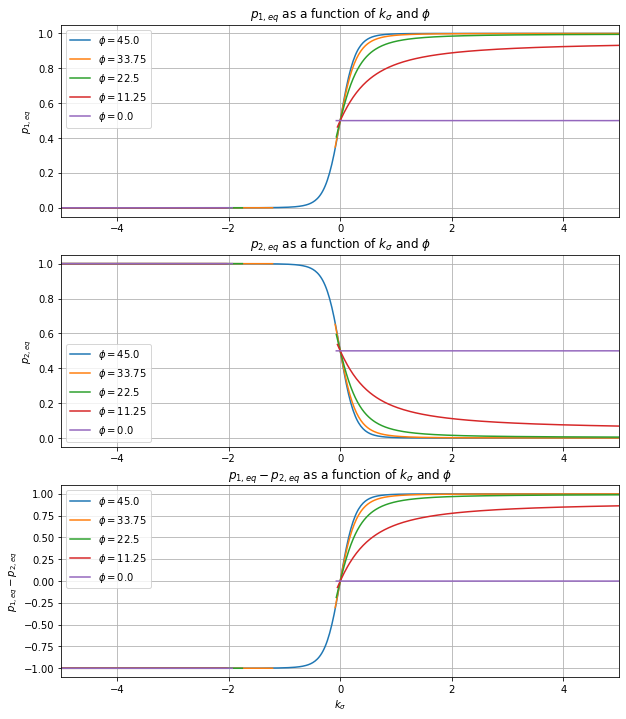

In [40]:
plt.figure(figsize=(10,12))

plt.subplot(311)
for i in range(len(phi_list)):
    phi = phi_list[i]
    plt.plot(k_s_list,p1_vs_phi[i],label = r'$\phi = $'+str(phi))
plt.legend(loc="best")
plt.grid(True)
#plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{1,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{1,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\phi$')

plt.subplot(312)
for i in range(len(phi_list)):
    phi = phi_list[i]
    plt.plot(k_s_list,p2_vs_phi[i],label = r'$\phi = $'+str(phi))
plt.legend(loc="best")
plt.grid(True)
#plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{2,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{2,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\phi$')

plt.subplot(313)
for i in range(len(phi_list)):
    phi = phi_list[i]
    plt.plot(k_s_list,np.array(p1_vs_phi[i])-np.array(p2_vs_phi[i]),label = r'$\phi = $'+str(phi))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$p_{1,eq}-p_{2,eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$p_{1,eq}-p_{2,eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\phi$')

plt.show()

## Behaviour of $m_{eq}$

$$m_{eq} = \cos{\theta_1}p_{1,eq}+\cos{\theta_2}p_{2,eq}$$

### 1. Influence of $\beta'$

In [126]:
#Computation
k_s_lim = 1
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
beta_prime_list = [1,2,5,10,50]
m_eq_vs_bp = []
for bp in beta_prime_list:
    spn.beta_prime = bp
    m_eq = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        c1 = np.cos(spn.get_theta_1()*np.pi/180)
        c2 = np.cos(spn.get_theta_2()*np.pi/180)
        p1 = spn.get_omega_prime_21()/spn.get_omega_prime()
        p2 = spn.get_omega_prime_12()/spn.get_omega_prime()
        m_eq.append(c1*p1+c2*p2)
    m_eq_vs_bp.append(m_eq)

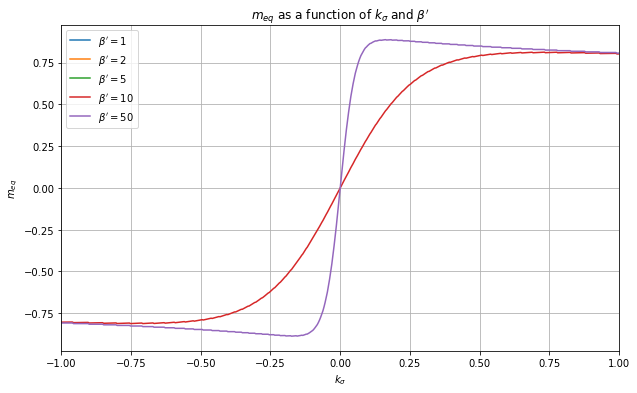

In [127]:
plt.figure(figsize=(10,6))
for i in range(len(beta_prime_list)):
    beta_prime = beta_prime_list[i]
    plt.plot(k_s_list,m_eq_vs_bp[i],label = r'$\beta^\prime = $'+str(beta_prime))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$m_{eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$m_{eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\beta^\prime$')
plt.show()

### 2. Influence of $h$

In [128]:
#Computation
k_s_lim = 1
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
h_list = np.logspace(-2,0,5)
m_eq_vs_h = []
for h in h_list:
    spn.h = h
    m_eq = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        c1 = np.cos(spn.get_theta_1()*np.pi/180)
        c2 = np.cos(spn.get_theta_2()*np.pi/180)
        p1 = spn.get_omega_prime_21()/spn.get_omega_prime()
        p2 = spn.get_omega_prime_12()/spn.get_omega_prime()
        m_eq.append(c1*p1+c2*p2)
    m_eq_vs_h.append(m_eq)

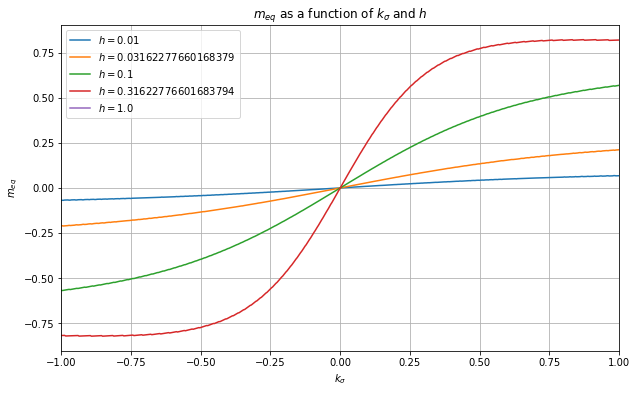

In [129]:
plt.figure(figsize=(10,6))
for i in range(len(h_list)):
    h = h_list[i]
    plt.plot(k_s_list,m_eq_vs_h[i],label = r'$h = $'+str(h))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$m_{eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$m_{eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$h$')
plt.show()

### 3. Influence of $\theta_H$

In [130]:
#Computation
k_s_lim = 1
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
theta_H_list = np.linspace(90,0,5)
m_eq_vs_th = []
for th in theta_H_list:
    spn.theta_H = th
    m_eq = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        c1 = np.cos(spn.get_theta_1()*np.pi/180)
        c2 = np.cos(spn.get_theta_2()*np.pi/180)
        p1 = spn.get_omega_prime_21()/spn.get_omega_prime()
        p2 = spn.get_omega_prime_12()/spn.get_omega_prime()
        m_eq.append(c1*p1+c2*p2)
    m_eq_vs_th.append(m_eq)

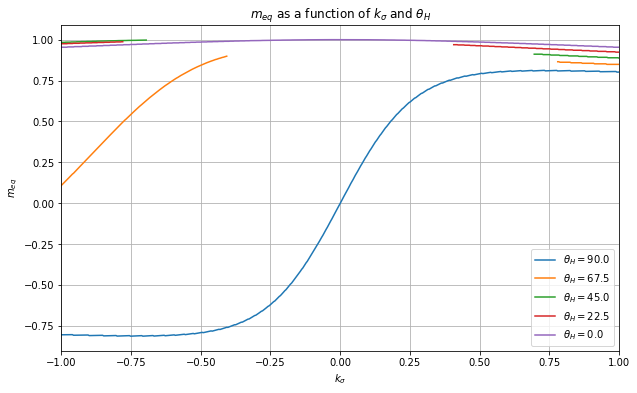

In [131]:
plt.figure(figsize=(10,6))
for i in range(len(theta_H_list)):
    theta_H = theta_H_list[i]
    plt.plot(k_s_list,m_eq_vs_th[i],label = r'$\theta_H = $'+str(theta_H))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$m_{eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$m_{eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\theta_H$')
plt.show()

### 4. Influence of $\phi$

In [132]:
#Computation
k_s_lim = 1
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
phi_list = np.linspace(45,0,5)
m_eq_vs_phi = []
for phi in phi_list:
    spn.phi = phi
    m_eq = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        c1 = np.cos(spn.get_theta_1()*np.pi/180)
        c2 = np.cos(spn.get_theta_2()*np.pi/180)
        p1 = spn.get_omega_prime_21()/spn.get_omega_prime()
        p2 = spn.get_omega_prime_12()/spn.get_omega_prime()
        m_eq.append(c1*p1+c2*p2)
    m_eq_vs_phi.append(m_eq)

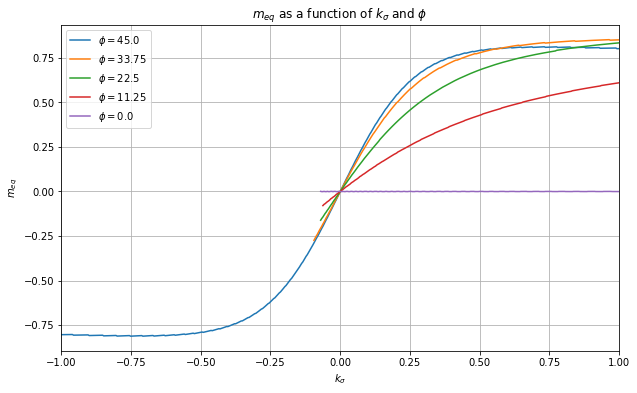

In [133]:
plt.figure(figsize=(10,6))
for i in range(len(phi_list)):
    phi = phi_list[i]
    plt.plot(k_s_list,m_eq_vs_phi[i],label = r'$\phi = $'+str(phi))
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$m_{eq}$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$m_{eq}$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\phi$')
plt.show()

## Behaviour of $e_{b,min}\beta'$

### 1. Influence of $\beta'$

In [67]:
#Computation
k_s_lim = 5
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
beta_prime_list = [1,2,5,10]
eb_vs_bp = []
for bp in beta_prime_list:
    spn.beta_prime = bp
    eb = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        eb.append(spn.get_e_b_min()*spn.beta_prime)
    eb_vs_bp.append(eb)

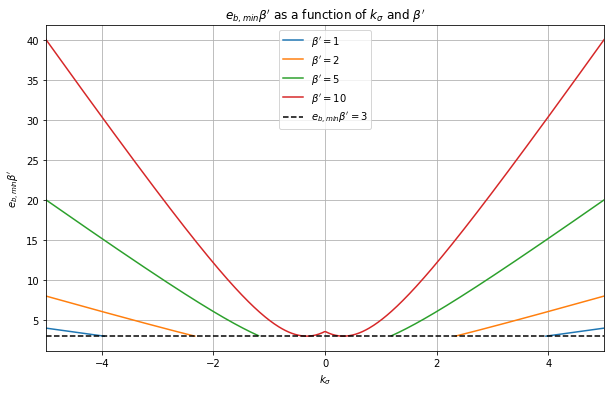

In [68]:
plt.figure(figsize=(10,6))
for i in range(len(beta_prime_list)):
    beta_prime = beta_prime_list[i]
    plt.plot(k_s_list,eb_vs_bp[i],label = r'$\beta^\prime = $'+str(beta_prime))
plt.axhline(y=3,linestyle='--',color="black",label=r'$e_{b,min}\beta^\prime=3$')
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$e_{b,min}\beta^\prime$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$e_{b,min}\beta^\prime$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\beta^\prime$')
plt.show()

### 2. Influence of $h$

In [69]:
#Computation
k_s_lim = 5
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
h_list = np.logspace(-2,0,5)
eb_vs_h = []
for h in h_list:
    spn.h = h
    eb = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        eb.append(spn.get_e_b_min()*spn.beta_prime)
    eb_vs_h.append(eb)

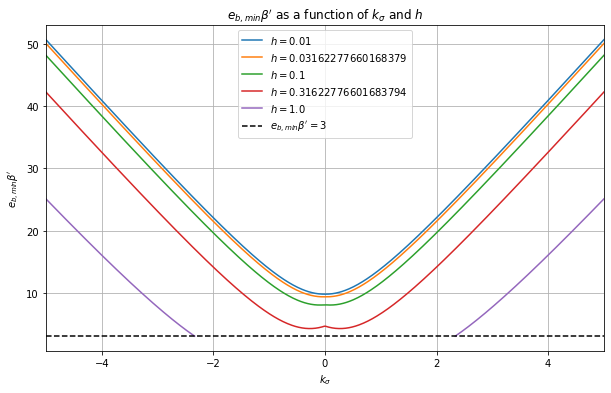

In [70]:
plt.figure(figsize=(10,6))
for i in range(len(h_list)):
    h = h_list[i]
    plt.plot(k_s_list,eb_vs_h[i],label = r'$h = $'+str(h))
plt.axhline(y=3,linestyle='--',color="black",label=r'$e_{b,min}\beta^\prime=3$')
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$e_{b,min}\beta^\prime$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$e_{b,min}\beta^\prime$' + " as a function of " + r'$k_\sigma$' + " and " + r'$h$')
plt.show()

### 3. Influence of $\theta_H$

In [57]:
#Computation
k_s_lim = 5
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
th_list = np.linspace(90,0,5)
eb_vs_th = []
for th in th_list:
    spn.theta_H = th
    eb = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        eb.append(spn.get_e_b_min()*spn.beta_prime)
    eb_vs_th.append(eb)

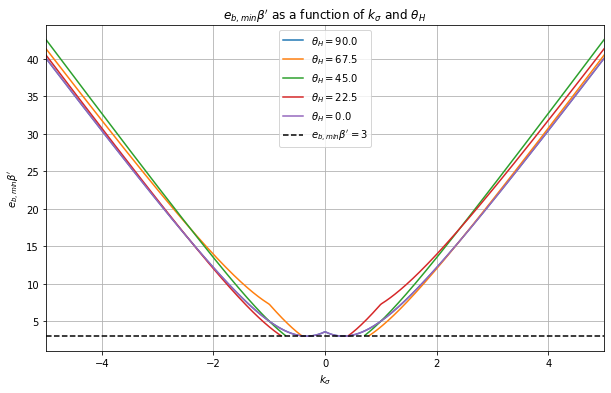

In [58]:
plt.figure(figsize=(10,6))
for i in range(len(theta_H_list)):
    theta_H = theta_H_list[i]
    plt.plot(k_s_list,eb_vs_th[i],label = r'$\theta_H = $'+str(theta_H))
plt.axhline(y=3,linestyle='--',color="black",label=r'$e_{b,min}\beta^\prime=3$')
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$e_{b,min}\beta^\prime$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$e_{b,min}\beta^\prime$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\theta_H$')
plt.show()

### 4. Influence of $\phi$

In [59]:
#Computation
k_s_lim = 5
spn = SP_Network(0.4,90,0,45,10)
k_s_list = np.linspace(-k_s_lim,k_s_lim,500)
phi_list = np.linspace(45,0,5)
eb_vs_phi = []
for phi in phi_list:
    spn.phi = phi
    eb = []
    for k_s in k_s_list:
        spn.k_s = k_s
        calculate_energy_barriers(spn)
        eb.append(spn.get_e_b_min()*spn.beta_prime)
    eb_vs_phi.append(eb)

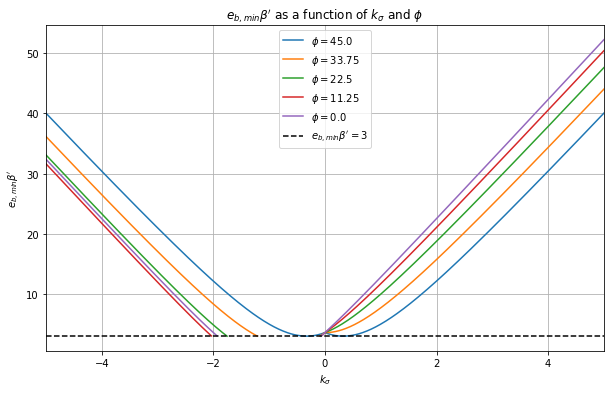

In [60]:
plt.figure(figsize=(10,6))
for i in range(len(phi_list)):
    phi = phi_list[i]
    plt.plot(k_s_list,eb_vs_phi[i],label = r'$\phi = $'+str(phi))
plt.axhline(y=3,linestyle='--',color="black",label=r'$e_{b,min}\beta^\prime=3$')
plt.legend(loc="best")
plt.grid(True)
plt.xlabel(r'$k_\sigma$')
plt.ylabel(r'$e_{b,min}\beta^\prime$')
plt.xlim(-k_s_lim,k_s_lim)
#plt.yscale("log")
plt.title(r'$e_{b,min}\beta^\prime$' + " as a function of " + r'$k_\sigma$' + " and " + r'$\phi$')
plt.show()

## Comments

* $\omega'$ is varying too much with $k_\sigma$ when $\beta'>3$.
* If we decrease $\beta'$, the condition $e_{b,min}$ won't be observed anymore.
* If we decrease $h$, $e_{b,min}$ increases but the range of $p_{eq}$ and $m_{eq}$ decrease a lot.
* The solution could be to decrease the range of $k_\sigma$!
* $\phi = 45°$ and $\theta_H = 90°$ seem to be good choices.